## GAN (Generative Adversarial Networks)

### Introduction

By its name, GAN is a type of generative deeping learning model. It is an intereting idea brought by by a group of researchers at the University of Montreal lead by Ian Goodfellow in 2014. The basic idea is that in this framework,there are two deep neural networks model: one is playing "generator" role by generating iminated samples from some distribution of data we are interested in (e.g. images). One is playing "discriminator" role by distinguishing real data samples and "fake" ones coming from the generator. On the other hand, generator are trained to "fool" the discriminator. Two networks compete with each other and Eventually, the generator is able to generate samples that are indistinguishable from "real" data.

So far GANs have been primarily applied to modelling natural images. It has reached considerable success in mimicking images from CIFAR-10 database and ImageNet. It also did incredibly well in sharpening lossy images (Goodfellow, 2016).


<img src="https://blog.openai.com/content/images/2017/02/gen_models_img_5.jpg" alt="Drawing" style="width: 300px;"/>
<center><b>Figure 1</b>. Generated images from CIFAR-10 Data base</center>

In general, generative models like GAN have the potential to understand and explain the underlying structure of the input data even when there are no labels. This is very desirable when working on data modelling problems in the real world, as unlabelled data is of course abundant, but getting labelled data is often expensive at best and impractical at worst. 
### Generative Model vs. Discriminative Model

The main difference in two types of model is that generative model estimates the underlying joint distribution of the data and labels $P(x, y)$, while the dicriminative model only models the posterior distribution $P(y|x)$. Generative models are generative in the sense that it can generate samples after the models learned sufficient information about underlying distribution. 

Explicit generative model either directly estimate the density function of the data using factorization (Naive Bayes, Gaussain Mixture Model) or EM methods or do some sort of approximation (variational models or MCMC). However, the distribution of high-dimensional data like images are extremely complicated and explicit estimation becomes very hard. GAN is an implicit generative model which is capable of learning internal essense of the data distribution without giving out explicit forms through its special design.

As mentioned above, generative models can extract insights from large unlabelled data set via semi-supervised learning. In addition, learning high-dimensional distribution is important in a wide variety of applied math and engineering domains. Also, generative models can be naturally incorporated in reinforcement learning in many different ways. (Goodfellow, 2016)

###  Main Framework and Loss Function

The main framework of GAN consists of two main components, a generator and a discriminator. Each component plays as adversary to the other in a "game". The main set-up can be shown in the diagram below:

<img src = "http://blog.aylien.com/wp-content/uploads/2016/08/gan.png"  alt="Drawing" style="width: 500px;"/>
<center><b>Figure 2</b>. Architecture of GAN. Source: https://ishmaelbelghazi.github.io/ALI</center>

Each of the component is implemented in deep neural networks. A generator takes "input noise" as some random vector and output an sample from the distribution we are interested in. An popular architecture of nowaday GAN that genereting images is a variation of DCGAN (Radford et al., 2015), which consists of several transposed convolution layers to "upsample" an input low dimension noise to a full-sized image.


<img src = http://lijiancheng0614.github.io/2016/12/07/2016_12_07_DCGAN/fig1.png  alt="Drawing" style="width:500px;"/>
<center><b>Figure 3</b>. Architecture of DCGAN Generator. Source: Radford et al., 2015) </center>

The disciminator network also consists of multiple convolution layers as binary classifier. In DCGAN Architecture, discriminator also has an all-convolution set-up similar to its generator. Batch normalization is used for all layers in generator and discriminator except the output layer in generator and the input layer in discriminator.

As for loss function, the loss for discriminator is a standard binary entropy. The loss for generator is more tricky. it can be simply the negative version of discriminator's loss, or "minimax" as called by GoodFellow. In this way, the dicriminator and generator are playing a zero-sum game. In practice, "minimax" cost for generator doesn't perform as well. GoodFellow (2016) used a more heuristic version of loss for generator that maximizes the probability that discriminator "was fooled". 

Alternatively GoodFellow (2016) also introduced a maximum likelihood version of loss, which would mean minimizing the KL divergence between the real data and the learned model. However, this version of loss gives high variance in practice.


### Mode Collapse and Other Challenges

GAN is still novel and faces many challenges in practice. One major challenge is "mode collapse". This refers to a phenomenon of collapsing of large volumes of probability mass onto a few modes: the generator learned to map the input only to a few classes of samples that can most easily fool the discriminator rather than learning a full spectrum of the distribution. Many efforts have tried to solve this problem including "Minibatch features" and unrolled GANs (Metz et al., 2016).

Besides, GAN has trouble to learn the optimal structure to integrate parts in an image. Sometimes GAN will generate wrong counts of head/eyes for an animal object. Also, it struggles to learn the idea of three-dimensional perspective.

### References

Goodfellow, Ian. "NIPS 2016 Tutorial: Generative Adversarial Networks." arXiv preprint arXiv:1701.00160 (2016).  

Goodfellow, Ian, et al. "Generative adversarial nets." Advances in neural information processing systems. 2014. 

Metz, Luke, et al. "Unrolled Generative Adversarial Networks." arXiv preprint arXiv:1611.02163 (2016).

Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).  

http://blog.aylien.com/introduction-generative-adversarial-networks-code-tensorflow/

### Simple use cases

Using Keras to build a simple GAN to generate handwritten digits

In [157]:
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

In [158]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Reshape,Conv2DTranspose, UpSampling2D
from keras.models import Model
from keras.callbacks import History

In [159]:
from keras.layers.core import Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import SGD, Adam
from keras.initializers import RandomNormal
from keras.constraints import maxnorm
from keras.datasets import mnist

In [160]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = np.concatenate([X_train, X_test], axis = 0)
#normalize
X_train = (X_train- 127.5)/127.5
#build random input for generator (uniform -1 to 1) same size as X_train
train_size = X_train.shape[0]
X_noise = np.random.uniform(-1,1,(train_size, 100))

adam=Adam(lr=0.0002, beta_1=0.5 )
init = RandomNormal(mean=0.0, stddev=0.02)

In [161]:
#build generator network
input_noise = Input(shape=(100,))
x = Dense(7*7*128, input_shape = (100,),kernel_initializer = init)(input_noise)
x = Activation(LeakyReLU(0.2))(x)
x = Reshape((7,7,128))(x)
x = Conv2DTranspose(64, (5,5), strides = (2,2), padding = "same")(x)
x = Activation(LeakyReLU(0.2))(x)
y = Conv2DTranspose(1, (5,5), strides = (2,2), activation='tanh', padding = "same")(x)

In [162]:
Generator = Model(input_noise, y)
Generator.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

In [163]:
#build discriminator network
input_gen = Input(shape=(28,28,1))
x = Conv2D(64, (5, 5), padding='same', strides = (2,2), kernel_initializer = init)(input_gen)
x = Activation(LeakyReLU(0.2))(x)
x = Conv2D(128, (5, 5), padding='same', strides = (2,2))(x)
x = Activation(LeakyReLU(0.2))(x)
x = Flatten()(x)
result = Dense(1, activation = "sigmoid")(x)

In [164]:
discriminator = Model(input_gen, result)
discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [165]:
#build the "generator on discriminator" graph, with no-update on discriminator 
discriminator.trainable = False

gen = Generator(input_noise)
output = discriminator(gen)
dcgan = Model(inputs=input_noise, outputs=output)
dcgan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

discriminator.trainable = True

In [166]:
#set-up training batch-size and epoches
nepoch = 50
batch_size = 128
numBatches = int(train_size/float(batch_size))
dLoss = []
gLoss = []

In [167]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=numBatches, shuffle = True)

In [222]:
#epoch = 3

In [ ]:
#load the trained model
dcgan.load_weights('my_model_weights.h5')
Generator.load_weights('generator_weights.h5')
discriminator.load_weights('discriminator_weights.h5')
#train the data in batches

for i in range(nepoch):
    batch = 0
    kf = KFold(n_splits=numBatches, shuffle = True)
    for _, batch_index in kf.split(X_train): 
        #due to the mechanism of sklearn doing kfolds, the first couple batches might have batch_size+1 samples
        cur_batch_size = len(batch_index)
        
        X_noise_batch = X_noise[batch_index]
        noiseDataBatch = Generator.predict(X_noise_batch)
        X_train_batch = X_train[batch_index].reshape(-1,28,28,1)
        
        dis_train = np.concatenate([noiseDataBatch, X_train_batch], axis = 0)
        dis_label = np.concatenate([np.zeros(cur_batch_size).astype(int),np.ones(cur_batch_size).astype(int)], axis = 0)
        #now train discriminator
        dis_train, dis_label = shuffle(dis_train, dis_label)
        dis_Loss = discriminator.train_on_batch(dis_train, dis_label)
        
        #now train generator
        gan_label = np.ones(cur_batch_size).astype(int)
        
        discriminator.trainable = False
        gan_Loss = dcgan.train_on_batch(X_noise_batch, gan_label)
        discriminator.trainable = True
        
        
        
        if batch%100 == 0:
            print 'epoch: ', epoch, 'batch: ',batch
            print dis_Loss, gan_Loss       
        batch += 1
    epoch += 1
    #input_r = np.random.rand(100).reshape(1,100)
    #gen_image = noiseDataBatch[10]*127.5+127.5
    #plt.imshow(gen_image.reshape(28, 28))
    #plt.gray()
    #plt.show()
     
    dLoss.append(dis_Loss)
    gLoss.append(gan_Loss)

In [227]:
#save all the weights for futures uses
dcgan.save_weights('dcgan_weights.h5')
Generator.save_weights('generator_weights.h5')
discriminator.save_weights('discriminator_weights.h5')

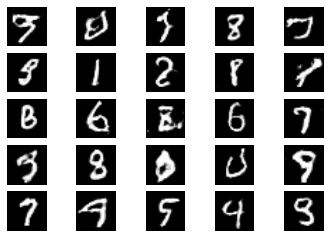

In [237]:
#randomly plot 25 generated digits after 50 epochs. The quality is not super but good enough to be recognized 
for i in range(25):
    input_r = np.random.uniform(-1,1,(1,100))
    gen_img = Generator.predict(input_r)*127.5 + 127.5
    ax = plt.subplot(5,5,i+1)
    plt.imshow(gen_img.reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()